In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 14.2 MB/s 


In [3]:
import pickle5 as pickle
with open('/content/drive/MyDrive/Colab Notebooks/thesis_PQAI/verbosity_model/coref_links/snippets_test_start.pickle','rb') as handle:
  a = pickle.load(handle)
a['snippets']

['dispensing within a liquid dispensing and suctioning system is controlled by pinching a flexible tube with a spring - biased actuator . the system includes a slidable extension for pulling the actuator to open the tube to dispense liquid to a surface to be cleaned . the system is assembled with a tubular wand of a wet / dry suctioning system .',
 'a composition and method for mineralizing and enhancing the flavor of brewed beverages such as coffee and tea is disclosed wherein a finely divided mineral . a coloring agent such as powdered caramel . and a particulate beverage base such as ground coffee are combined to form an admixture . the admixture is placed on a filter and hot water is added .',
 'a one - piece device formed from a rigid but deformable polymerized resin that may be selectively used as a comb on a woman &# 39 . s hair during drying of the latter in a stream of warmed air or as a support for a cylindrical hair roller shell that has at least one row of longitudinally sp

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 120 kB 68.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 


In [ ]:
import pickle5 as pickle
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import SVC
from scipy.stats import pearsonr
import torch.nn as nn
import torch
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score,r2_score,classification_report
import matplotlib.pyplot as plt
#from transformers import BertTokenizer, BertModel
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#For Queries

with open('queries.txt','r') as file:
  articles = file.readlines()

article_sentences = []
for text in articles:
  sents = sent_tokenize(text.strip())
  article_sentences.append(sents)

In [ ]:
with open('all_articles.pickle','rb') as handle:
  articles = pickle.load(handle)
article_sentences = []
for text in articles:
  sents = sent_tokenize(text)
  article_sentences.append(sents)

LookupError: ignored

### 1. Topic Modelling

In [ ]:
### Collect features from BERT-for-Patent model for every sentence (Do not delete)

def collect_features_for(articles):
  tokenizer = BertTokenizer.from_pretrained('anferico/bert-for-patents')
  model = BertModel.from_pretrained('anferico/bert-for-patents')
  article_features = []
  folder_path = 'query_article_feats'
  start_index = len(os.listdir(folder_path))

  for i,sent_group in enumerate(articles[start_index:]):
    print('Collecting features for article ',start_index+i)
    all_sent_features = []
    for sent in sent_group:
      inputs = tokenizer(sent,return_tensors="pt")
      outputs = model(**inputs,output_hidden_states=True)
      pooling = torch.nn.AvgPool2d(outputs.hidden_states[-2].shape[1], 1)
      sentence_features = pooling(outputs.hidden_states[-2])
      np_sent_feats = sentence_features.detach().cpu().detach().numpy().flatten()
      all_sent_features.append(np_sent_feats)
    
    article_features.append(all_sent_features)
    with open(folder_path+'/'+str(start_index+i)+'.pickle', 'wb') as handle:
      pickle.dump(all_sent_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('Features saved in '+folder_path+' folder.')

In [ ]:
collect_features_for(article_sentences)

In [ ]:
def pad_max_len(vect):
  max_len = 0
  for i in vect:
    if len(i) > max_len:
      max_len = len(i)
  for j in range(len(vect)):
    if len(vect[j]) < max_len:
      count = max_len - len(vect[j])
      vect[j] = np.concatenate((vect[j],np.zeros(count)),axis=None)
  return np.stack(vect)

In [ ]:
folder_name = 'query_article_feats'
segments = []
for index in range(len(article_sentences)):
  file_name = folder_name+'/'+str(index)+'.pickle'
  print(file_name)
  with open(file_name, 'rb') as handle:
      feat_vect = pickle.load(handle)
  feat_vect_padded = pad_max_len(feat_vect)

  #Similarity Matrix
  sim_mat = np.zeros((len(feat_vect_padded),len(feat_vect_padded)))
  for i in range(len(feat_vect_padded)):
    for j in range(len(feat_vect_padded)):
      sim_val = cosine_similarity([feat_vect_padded[i]],[feat_vect_padded[j]])
      sim_mat[i][j] = sim_val

  req_len=3
  if sim_mat.shape[0] > req_len:
    num_clusters = int(sim_mat.shape[0]/req_len)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(sim_mat)
    clusters = set(kmeans.labels_)
    for i in clusters:
      filtered_indexes = np.where(kmeans.labels_ == i)
      if len(filtered_indexes[0] ) > 1:
        segments.append(' '.join(list(map(article_sentences[index].__getitem__, filtered_indexes[0].tolist()))))

    #for k in range(len(sim_mat)):
    #  filtered_indexes = np.where(sim_mat[k] > 0.6)
    #  if len(filtered_indexes[0] ) > 3:
    #    segments.append(' '.join(list(map(article_sentences[index].__getitem__, filtered_indexes[0].tolist()))))

In [ ]:
segments

In [ ]:
with open('topic_segments_q.pickle','wb') as handle:
  pickle.dump(segments, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
df = pd.DataFrame({'abstract':segments})
df.to_csv('filtered_topic_segments_q.csv')

In [ ]:
import re
filtered_seg = []
for i in range(len(a)):
  if len(re.findall(r'\w+', a[i])) >= 60:
    filtered_seg.append(a[i])
len(filtered_seg)

with open('filtered_topic_segments.pickle','wb') as handle:
  pickle.dump(filtered_seg, handle, protocol=pickle.HIGHEST_PROTOCOL)
  df = pd.DataFrame({'abstract':filtered_seg})
df.to_csv('filtered_topic_segments.csv')

9029

#### Collecting Features from the folders.

In [ ]:
def feature_matrix(feat_type,snippet_pos):
  feat_dir_path = os.path.join('features',feat_type,snippet_pos)
  files = sorted(os.listdir(feat_dir_path))
  print(files)

  feats = {}
  for name in files:
    if name != 'syntactic_real.pickle':
      with open(os.path.join(feat_dir_path,name),'rb') as handle:
        dict_feat = pickle.load(handle)
      feats.update(dict_feat)
      
  df = pd.DataFrame(feats)
  df_temp = df[['temporal','comparison','expansion','contingency']].sum(axis=1)
  df['total_discourse'] = df_temp


  '''
  #Read Amount of detail features
  with open(os.path.join(feat_dir_path,'compression_likelihood.pickle'),'rb') as handle:
    dict_amount_of_detail = pickle.load(handle)
  amount_of_detail = np.array(dict_amount_of_detail['compression_likelihood'],dtype=float)

  '''

  #Read syntactic realization features
  with open(os.path.join(feat_dir_path,'syntactic_real.pickle'),'rb') as handle:
    dict_syntactic_real = pickle.load(handle)
  syn_real_non_np = np.array(dict_syntactic_real['non_nps_prod_count'])
  syn_real_np = np.array(dict_syntactic_real['nps_prod_count'])
  syn_real = np.concatenate((syn_real_non_np,syn_real_np), axis=1)
  
  verbosity_feats = np.concatenate((df.values,syn_real), axis=1)

  #Read Labels
  label_path = os.path.join('features',feat_type,'abstract_len.pickle')
  with open(label_path,'rb') as handle:
    labels = pickle.load(handle)

  return verbosity_feats,labels,df

In [ ]:
segment_feats,segment_labels,df_segment = feature_matrix('segment_features','start')

['amount_of_detail.pickle', 'compression_likelihood.pickle', 'continuity.pickle', 'discourse_relations.pickle', 'len_units.pickle', 'syntactic_real.pickle']


In [ ]:
# Binning of sample features
# we decide to make bins for every 30 words of length
# Hence the minimum length is 60 and max length is 240.
# hence we make 6 bins i.e., 60-90,91-120,121-150,151-180,181-210,210-240

#Collect the indexes for each length range
segment_labels = np.array(segment_labels)
ind_bin1 = np.where((segment_labels >= 60) & (segment_labels <= 90))[0]
ind_bin2 = np.where((segment_labels > 90) & (segment_labels <= 120))[0]
ind_bin3 = np.where((segment_labels > 120) & (segment_labels <= 150))[0]
ind_bin4 = np.where((segment_labels > 150) & (segment_labels <= 180))[0]
ind_bin5 = np.where((segment_labels > 180) & (segment_labels <= 210))[0]
ind_bin6 = np.where((segment_labels > 210) & (segment_labels <= 240))[0]

bin1_feats = segment_feats[ind_bin1]
bin2_feats = segment_feats[ind_bin2]
bin3_feats = segment_feats[ind_bin3]
bin4_feats = segment_feats[ind_bin4]
bin5_feats = segment_feats[ind_bin5]
bin6_feats = segment_feats[ind_bin6]

bin1_labels = segment_labels[ind_bin1]
bin2_labels = segment_labels[ind_bin2]
bin3_labels = segment_labels[ind_bin3]
bin4_labels = segment_labels[ind_bin4]
bin5_labels = segment_labels[ind_bin5]
bin6_labels = segment_labels[ind_bin6]

### 2. Length Prediction Model

In [ ]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [ ]:
query_feats,query_labels,df_query = feature_matrix('queries','start')

['amount_of_detail.pickle', 'compression_likelihood.pickle', 'continuity.pickle', 'discourse_relations.pickle', 'len_units.pickle', 'syntactic_real.pickle']


In [ ]:
query_feats.shape

(11, 87)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(segment_feats, segment_labels, test_size=0.1, random_state=42)

In [ ]:
mod = sm.OLS(y_train,X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              2177.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:27:36   Log-Likelihood:                         -36701.
No. Observations:                8126   AIC:                                  7.353e+04
Df Residuals:                    8061   BIC:                                  7.399e+04
Df Model:                          65                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
np.where(res.params>0)[0]

array([ 1,  5,  6,  7,  9, 16, 18, 22, 25, 27, 32, 33, 35, 36, 37, 41, 42,
       44, 47, 48, 50, 51, 52, 53, 54, 55, 58, 59, 60, 61, 62, 63, 72, 78,
       81, 86])

In [ ]:
indexes = np.where(res.params<0)[0]
cols = [df_segment.columns[i] if i < 57 else '' for i in indexes ]
coef = res.params[np.where(res.params<0)[0]]
p_vals = res.pvalues[np.where(res.params<0)[0]]
zipped = zip(indexes,cols,coef,p_vals)

In [ ]:
sorted(zipped, key=lambda x: x[2])

[(34, 'prod_cl', -16.893616175563626, 0.4680266047328344),
 (38, 'avg_sim', -13.9675723974409, 3.749498206002427e-10),
 (46, 'num_sents', -9.984407789007399, 3.736570483600889e-27),
 (19, VP -> MD VP, -2.3370618804732195, 3.88154604123571e-06),
 (29, SBAR -> WHADVP S, -1.919861917355055, 0.2179990585578057),
 (20, ADVP -> IN RBS, -1.8406151534245025, 0.08311391244153961),
 (43, 'comparison', -1.4337671925749513, 0.6425997232717051),
 (56, 'total_discourse', -1.218618093879496, 0.1299339277935235),
 (83, '', -1.217814532489169, 0.4514397128945178),
 (14, VP -> TO VP, -1.1812907944050262, 0.000634182382377704),
 (12, WHNP -> WDT, -1.0898210423325323, 0.23772239833890912),
 (85, '', -1.0549017500107392, 0.01114479971923191),
 (26, ROOT -> SBAR, -0.9182808329439343, 0.4091561147807432),
 (13, NP -> CD, -0.8820723936147262, 0.12575290516337964),
 (76, '', -0.8820723936146798, 0.12575290516339963),
 (31, S -> CC NP VP ., -0.6216169282502949, 0.5414932834927457),
 (30, ROOT -> FRAG, -0.597348

#### Prediction on Queries

In [ ]:
list_vals = list(zipped)
for i in range(len(list_vals)):
  val = list_vals[i][0]
  pval = list_vals[i][1]
  print(np.where(res.params == val)[0])

In [ ]:
np.where(res.params == list_vals[0])

IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt

AttributeError: ignored

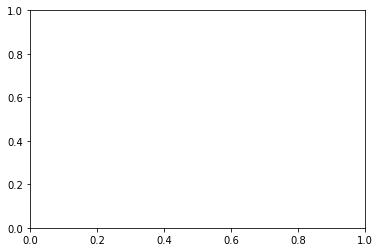

In [ ]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res.predict(X_test), 0, ax=ax)
ax.set_ylabel("Cancer")
ax.set_xlabel("Population")
ax.set_title("Linear Regression")

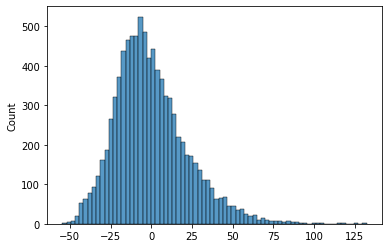

In [ ]:
import seaborn as sns
sns.histplot(res.resid);

In [ ]:
from scipy import stats
mu, std = stats.norm.fit(res.resid)
mu, std

(0.016382114194771386, 22.190241608011576)

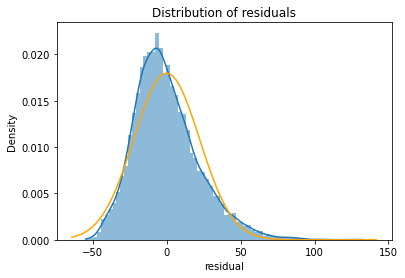

In [ ]:
fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=res.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

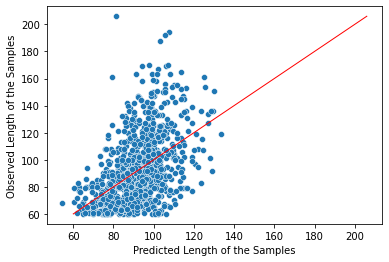

In [ ]:
Y_max = max(y_test)
Y_min = min(y_test)
ax = sns.scatterplot(x=res.predict(X_test), y=y_test)
#ax.set(ylim=(Y_min, Y_max))
#ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted Length of the Samples")
ax.set_ylabel("Observed Length of the Samples")
X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

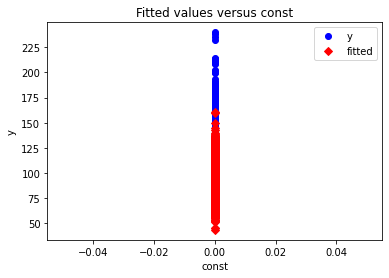

In [ ]:
sm.graphics.plot_fit(res,1, vlines=False);

In [ ]:
query_pred = res.predict(query_feats)

In [ ]:
query_pred,query_labels

(array([ 85.51998311,  88.21041006,  87.47157969,  84.33632661,
         88.47789092,  83.99089666,  56.13110858,  75.87837803,
         93.93121781, 104.77569139,  87.46053541]),
 [51, 47, 36, 41, 57, 37, 36, 47, 62, 47, 56])

In [ ]:
r2_score(query_labels,query_pred)

0.3641879297248316

In [ ]:
from scipy.stats.stats import pearsonr,spearmanr,kendalltau

In [ ]:
pearsonr(y_test,res.predict(X_test))

(0.4545637917215472, 8.775368666942796e-93)

In [ ]:
spearmanr(y_test,res.predict(X_test))

SpearmanrResult(correlation=0.4569894090870902, pvalue=7.04213160266263e-94)

In [ ]:
kendalltau(y_test,res.predict(X_test))

KendalltauResult(correlation=0.31853168145195926, pvalue=2.729365721980658e-90)

### 2. Length Range Prediction model

In [ ]:
train_feats,train_labels,df_train = feature_matrix('train','end')
val_feats,val_labels,df_val = feature_matrix('val','end')
test_feats,test_labels,df_test = feature_matrix('test','end')

In [ ]:
def identify_columns_with_zero(feats):
  cols_with_zero = []
  for i in range(feats.shape[1]):
      values = feats[:,i]
      if np.min(values) == 0 and np.max(values) == 0:
        cols_with_zero.append(i)
  return cols_with_zero

In [ ]:
column_with_zeros_indexes = identify_columns_with_zero(train_feats)
train_feats_n = np.delete(train_feats, column_with_zeros_indexes, axis=1)
val_feats_n = np.delete(val_feats, column_with_zeros_indexes, axis=1)
test_feats_n = np.delete(test_feats, column_with_zeros_indexes, axis=1)

In [ ]:
train_labels_np = np.array(train_labels)
indexes_of_below_hund = np.where(train_labels_np < 200)[0]
train_feats_selected_len = train_feats_n[indexes_of_below_hund]
train_labels_selected_len = train_labels_np[indexes_of_below_hund]

In [ ]:
test_labels_np = np.array(test_labels)
indexes_ = np.where(test_labels_np < 200)[0]
test_feats_selected_len = test_feats_n[indexes_]
test_labels_selected_len = test_labels_np[indexes_]

In [ ]:
#train_feats_selected_len.shape

scaler = StandardScaler()
train_feats_n = scaler.fit_transform(train_feats_n)
val_feats_n = scaler.transform(val_feats_n)
test_feats_n = scaler.transform(test_feats_n)

In [ ]:
for i in range(len(test_labels)):
  if test_labels[i] <= 50:
    print(i,'->',test_labels[i])

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=25, encode='ordinal', strategy='uniform')

x_train_binned = est.fit_transform(train_feats_n)
x_val_binned = est.transform(val_feats_n)
x_test_binned = est.transform(test_feats_n)

In [ ]:
def allocat_label(counts):
  dict_len_counts = {'50':0,'50-100':0,'100-150':0,'150-200':0,'200-250':0,'250-300':0,'300-350':0,'350-400':0,'400+':0}
  arr_labels = []
  for index,i in enumerate(counts):
    if i <=50:
      dict_len_counts['50'] += 1
      arr_labels.append(0)
    elif i>50 and i<=100:
      dict_len_counts['50-100'] += 1
      arr_labels.append(0)
    elif i>100 and i<=150:
      dict_len_counts['100-150'] += 1
      arr_labels.append(1)
    elif i>150 and i<=200:
      dict_len_counts['150-200'] += 1
      arr_labels.append(1)
    elif i>200 and i<=250:
      dict_len_counts['200-250'] += 1
      arr_labels.append(2)
    elif i>250 and i<=300:
      dict_len_counts['250-300'] += 1
      arr_labels.append(2)
    elif i>300 and i<=350:
      dict_len_counts['300-350'] += 1
      arr_labels.append(3)
    elif i>350 and i<=400:
      dict_len_counts['350-400'] += 1
      arr_labels.append(3)
    elif i>400:
      dict_len_counts['400+'] += 1
      arr_labels.append(3)
  return arr_labels

In [ ]:
arr_labels_np = np.array(allocat_label(train_labels))
one_hot_train_labels = np.zeros((arr_labels_np.size, arr_labels_np.max()+1))
one_hot_train_labels[np.arange(arr_labels_np.size),arr_labels_np] = 1
one_hot_train_labels[0]

array([1., 0., 0., 0.])

In [ ]:
val_labels_np = np.array(allocat_label(val_labels))
one_hot_val_labels = np.zeros((val_labels_np.size, val_labels_np.max()+1))
one_hot_val_labels[np.arange(val_labels_np.size),val_labels_np] = 1
y_val = torch.tensor(one_hot_val_labels,dtype=torch.float32)
y_val[0]

tensor([1., 0., 0., 0.])

In [ ]:
test_labels_np = np.array(allocat_label(test_labels))
one_hot_test_labels = np.zeros((test_labels_np.size, test_labels_np.max()+1))
one_hot_test_labels[np.arange(test_labels_np.size),test_labels_np] = 1
y_test = torch.tensor(one_hot_test_labels,dtype=torch.float32)
y_test[0]

tensor([0., 1., 0., 0.])

In [ ]:
train_feats_selected_len.shape

(10790, 70)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC

In [ ]:
pipeline = make_pipeline(SelectKBest(chi2, k=56),StandardScaler(), RandomForestClassifier(max_depth=36, random_state=0))
pipeline.fit(train_feats_selected_len, allocat_label(train_labels_selected_len))
y_pred = pipeline.predict(test_feats_selected_len)
score = accuracy_score(allocat_label(test_labels_selected_len),y_pred)
print(score)

0.6258169934640523


In [ ]:
from sklearn.metrics import precision_score,recall_score,classification_report,f1_score

In [ ]:
precision_score(allocat_label(test_labels_selected_len),y_pred,average='weighted')

0.6184507097314178

In [ ]:
recall_score(allocat_label(test_labels_selected_len),y_pred,average='weighted')

0.6176470588235294

In [ ]:
f1_score(allocat_label(test_labels_selected_len),y_pred,average='weighted')

0.618022688002404

In [ ]:
print(classification_report(allocat_label(test_labels_selected_len),y_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       259
           1       0.67      0.66      0.67       353

    accuracy                           0.62       612
   macro avg       0.61      0.61      0.61       612
weighted avg       0.62      0.62      0.62       612



In [ ]:
from xgboost import XGBClassifier

In [ ]:
pipeline = make_pipeline(SelectKBest(chi2, k=56),StandardScaler(), XGBClassifier(max_depth=2,learning_rate=0.08,colsample_bytree=0.4))
pipeline.fit(train_feats_selected_len, allocat_label(train_labels_selected_len))
y_pred = pipeline.predict(test_feats_selected_len)
test_lab_true = allocat_label(test_labels_selected_len)
score = accuracy_score(test_lab_true,y_pred)
precision = precision_score(test_lab_true,y_pred)
recall = recall_score(test_lab_true,y_pred)
f1 = f1_score(test_lab_true,y_pred)
print(score,precision,recall,f1)

0.6176470588235294 0.670487106017192 0.6628895184135978 0.6666666666666667


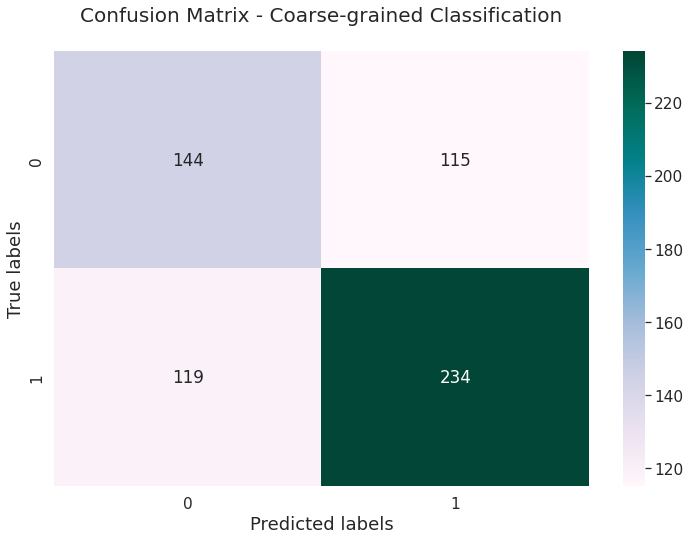

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(confusion_matrix(allocat_label(test_labels_selected_len),y_pred), annot=True, ax = ax,fmt='g',cmap='PuBuGn'); #annot=True to annotate cells
sns.set(font_scale=1.4)
# labels, title and ticks
ax.set_xlabel('Predicted labels').set_fontsize('18')
ax.set_ylabel('True labels').set_fontsize('18')
ax.set_title('Confusion Matrix - Coarse-grained Classification',pad = 30).set_fontsize('20')
#ax.xaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#ax.yaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#plt.savefig('cm.png',bbox_inches='tight')

#### Deep Learning method

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using CPU instead.')
    device = torch.device("cpu")

GPU: Tesla T4


In [ ]:
X_train = torch.tensor(x_train_binned,dtype=torch.float32)
y_train = torch.tensor(one_hot_train_labels,dtype=torch.float32)

In [ ]:
X_train[0]

tensor([ 2.,  9., 12.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  4., 24., 17.,
         7.,  4., 11.,  6.,  7.,  5.,  3.,  0.,  0.,  2., 24., 17.,  3.,  0.,
         3.,  0.,  4.,  0.,  0.,  0.,  4.,  3.,  3.,  0.,  0.,  0.,  6.,  0.,
         0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  4., 17.,  0.,  1.,  0.,  1.,
         3.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.])

In [ ]:
class VerbosityModel(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.linear1 = nn.Linear(in_features=70, out_features=14, bias=True)
      self.linear2 = nn.Linear(in_features=14, out_features=10, bias=True)
      self.linear3 = nn.Linear(in_features=10, out_features=2, bias=True)
      self.dropout = nn.Dropout(0.2)
      self.sigmoid = nn.Sigmoid()
  def forward(self,input):
    out_lin1 = torch.relu(self.linear1(input))
    out_lin2 = torch.relu(self.linear2(out_lin1))
    out_lin3 = torch.relu(self.linear3(out_lin2))
    output = self.sigmoid(out_lin3)
    return output

In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
#Val feats
#val_feats_norm = scaler.transform(selector.transform(val_feats))
X_val = torch.tensor(x_val_binned,dtype=torch.float32)
X_test = torch.tensor(x_test_binned,dtype=torch.float32)

tensor([0., 1.])

In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

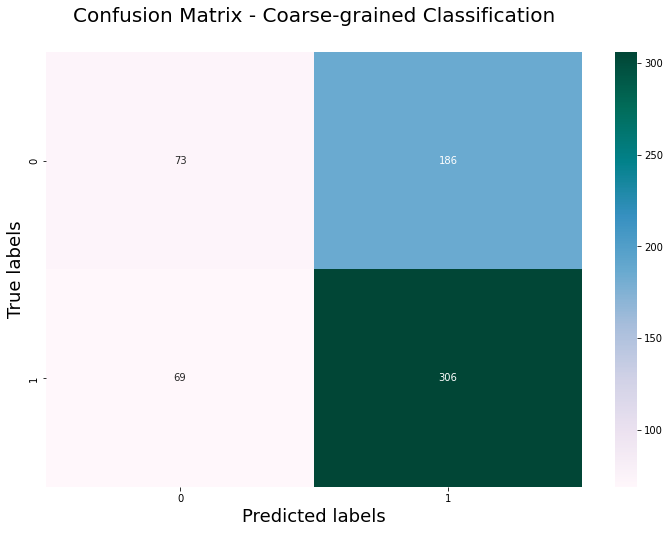

In [ ]:
plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_labels_np,y_pred), annot=True, ax = ax,fmt='g',cmap='PuBuGn'); #annot=True to annotate cells
sns.set(font_scale=1.4)
# labels, title and ticks
ax.set_xlabel('Predicted labels').set_fontsize('18')
ax.set_ylabel('True labels').set_fontsize('18')
ax.set_title('Confusion Matrix - Coarse-grained Classification',pad = 30).set_fontsize('20')
#ax.xaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#ax.yaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#plt.savefig('cm.png',bbox_inches='tight')

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest, chi2,f_regression
from sklearn.svm import SVR

In [ ]:
def identify_columns_with_zero(feats):
  cols_with_zero = []
  for i in range(feats.shape[1]):
      values = feats[:,i]
      if np.min(values) == 0 and np.max(values) == 0:
        cols_with_zero.append(i)
  return cols_with_zero

In [ ]:
column_with_zeros_indexes = identify_columns_with_zero(train_feats)
train_feats_n = np.delete(train_feats, column_with_zeros_indexes, axis=1)
val_feats_n = np.delete(val_feats, column_with_zeros_indexes, axis=1)
test_feats_n = np.delete(test_feats, column_with_zeros_indexes, axis=1)

In [ ]:
train_labels_np = np.array(train_labels)
indexes_of_below_hund = np.where(train_labels_np < 150)[0]
train_feats_selected_len = train_feats_n[indexes_of_below_hund]
train_labels_selected_len = train_labels_np[indexes_of_below_hund]

In [ ]:
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(train_feats_n)
x_test_norm = scaler.transform(test_feats_n)
for i in range(1,70):

  selector = SelectKBest(f_regression, k=i)
  x_train_selected = selector.fit_transform(x_train_norm, train_labels)
  x_test_selected = selector.transform(test_feats_n)

  

  #reg = SGDRegressor(max_iter=500, tol=1e-2)
  reg = SVR(kernel = 'rbf',C=1.0, epsilon=0.2)
  reg.fit(x_train_selected,train_labels)
  print(i,': ',reg.score(x_train_selected,train_labels),reg.score(x_test_selected,test_labels))

1 :  0.001627953665712445 0.009726333178773805
2 :  0.009830871888323989 0.007007169786487855
3 :  0.010155990292029515 0.006844879415463079
4 :  0.01801489538276535 0.0025159953947793134
5 :  0.018030805670093297 0.009390487999533015
6 :  0.019943479101534045 0.014328423921205702
7 :  0.026490790895566718 -0.005104235025314541
8 :  0.031001196837479483 -0.02391120346029152
9 :  0.037143200007989874 -0.013535506898509908
10 :  0.03772635759993037 -0.016620438817731564
11 :  0.04229200583613568 -0.01379080287751644
12 :  0.04280543658340408 -0.01269701030460113
13 :  0.04272573230429999 -0.009709670152665328
14 :  0.04282622069022679 -0.007340192069908991
15 :  0.04851280166853045 -0.008609969241616389
16 :  0.04764984458138899 -0.007525270200327894
17 :  0.05114856831889314 -0.013206811610143587
18 :  0.05376390710490686 -0.011297332757471912
19 :  0.05383924496754788 -0.010188196438234431
20 :  0.05366280718430971 -0.005161577858080912
21 :  0.054934989556407965 -0.0019059291335323802

KeyboardInterrupt: ignored

0.0896113600750863

In [ ]:
y_pred = reg.predict(x_test_norm)

In [ ]:
train_labels[:5]

[83, 71, 183, 151, 60]

In [ ]:
y_pred[:5]

array([68.55913296, 73.88770746, 63.13306621, 62.59913308, 87.96282314])

In [ ]:
reg.score(x_test_norm,test_labels)

-0.2708893667137866

In [ ]:
#model = torch.nn.Linear(in_features=87, out_features=1, bias=True)
model = VerbosityModel()
model.cuda()
#loss = torch.nn.MSELoss()
#loss = RMSLELoss()
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
n_epoch = 20
for i in range(n_epoch):
  for step, batch in enumerate(train_dataloader):
    b_train_feats = batch[0].to(device)
    b_train_labels = batch[1].to(device)
    
    model.train()
    y_pred = model(b_train_feats)
    
    step_loss = loss(y_pred, b_train_labels)
    optimizer.zero_grad()
    step_loss.backward()
  # update with current step regression parameters 
    optimizer.step()

  
  model.eval()
  with torch.no_grad():
    val_pred = model(X_val.to(device))
    val_loss = loss(val_pred,y_val.to(device))
  y_pred_val_np = val_pred.cpu().detach().numpy()
  #print(y_pred_val_np[1])
  
  
  max_val = np.argmax(y_pred_val_np,axis=1)
  
  all_val_labels = y_val.to('cpu').numpy()
  max_val_true = np.argmax(all_val_labels,axis=1)

  acc = accuracy_score(max_val,max_val_true)
  

    
  print ('epoch [{}], Loss: {:.2f}, Val_loss:{:.2f}, accuracy:{:.2f} '.format(i, step_loss.item(),val_loss,acc))

epoch [0], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [1], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [2], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [3], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [4], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [5], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [6], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [7], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [8], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [9], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [10], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [11], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [12], Loss: 0.70, Val_loss:0.69, accuracy:0.42 
epoch [13], Loss: 0.69, Val_loss:0.69, accuracy:0.42 
epoch [14], Loss: 0.69, Val_loss:0.69, accuracy:0.42 


KeyboardInterrupt: ignored

In [ ]:
model.eval()
with torch.no_grad():
  test_pred = model(X_test.to(device))
val_loss = loss(test_pred,y_test.to(device))
y_pred_test_np = test_pred.cpu().detach().numpy()


max_val_test = np.argmax(y_pred_test_np,axis=1)

all_test_labels = y_test.to('cpu').numpy()
max_test_true = np.argmax(all_test_labels,axis=1)

acc_test = accuracy_score(max_val_test,max_test_true)

In [ ]:
acc_test

0.5899053627760252

In [ ]:
max_val_test

In [ ]:
max_test_true

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 3, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 3, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 2, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 2, 0, 1,

In [ ]:
print(classification_report(max_test_true,max_val_test))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40       259
           1       0.62      0.77      0.69       375

    accuracy                           0.59       634
   macro avg       0.56      0.55      0.54       634
weighted avg       0.57      0.59      0.57       634



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

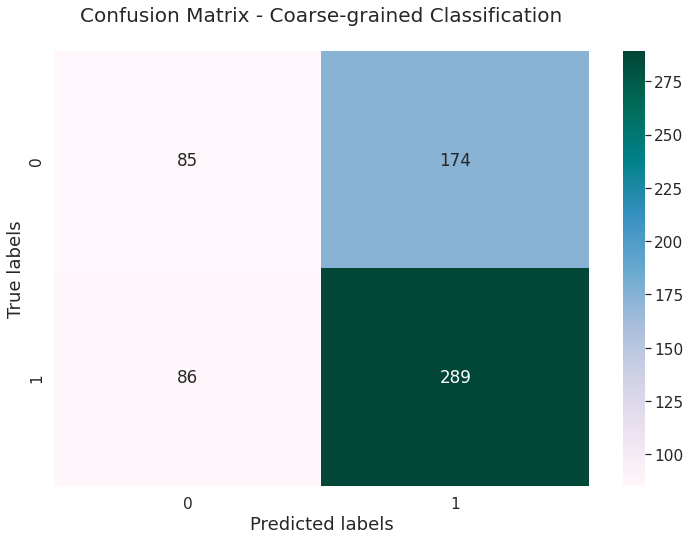

In [ ]:
plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.heatmap(confusion_matrix(max_test_true,max_val_test), annot=True, ax = ax,fmt='g',cmap='PuBuGn'); #annot=True to annotate cells
sns.set(font_scale=1.4)
# labels, title and ticks
ax.set_xlabel('Predicted labels').set_fontsize('18')
ax.set_ylabel('True labels').set_fontsize('18')
ax.set_title('Confusion Matrix - Coarse-grained Classification',pad = 30).set_fontsize('20')
#ax.xaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#ax.yaxis.set_ticklabels(['Gramm. Correct','Gramm. Incorrect'],rotation=0)
#plt.savefig('cm.png',bbox_inches='tight')